Section 3

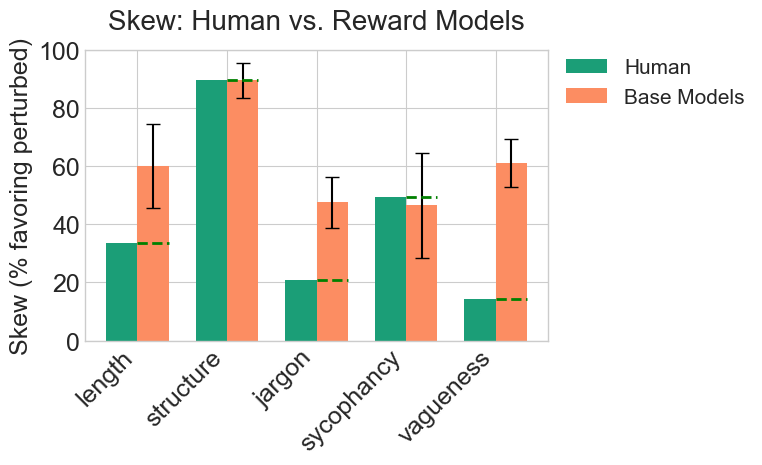

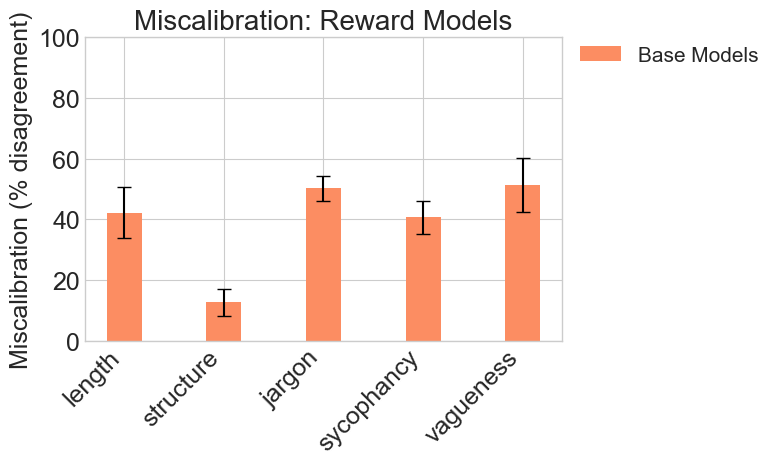

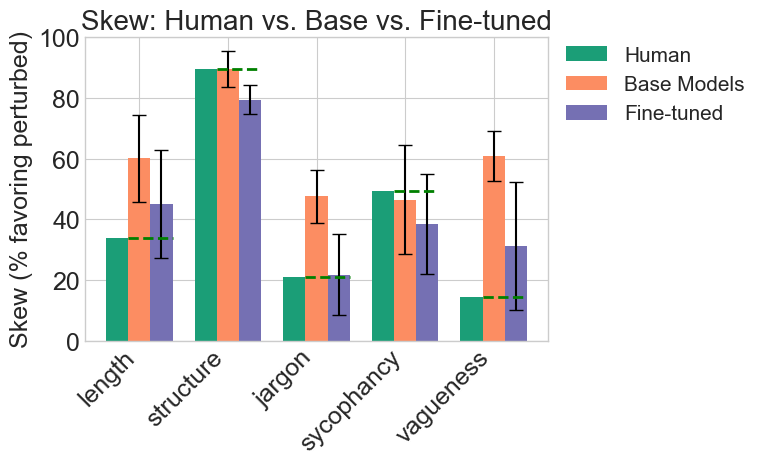

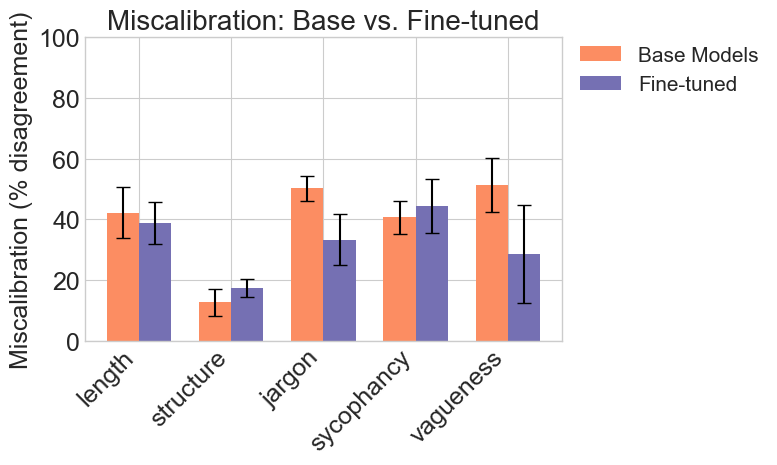

{'structure': 89.47368421052632, 'jargon': 20.87912087912088, 'length': 33.70786516853933, 'sycophancy': 49.411764705882355, 'vagueness': 14.285714285714285}
                 skew     miscal
structure   89.473684  12.631579
jargon      47.527473  50.274725
length      60.112360  42.134831
sycophancy  46.470588  40.588235
vagueness   60.969388  51.275510
                 skew     miscal
structure   79.473684  17.368421
jargon      21.703297  33.241758
length      44.943820  38.764045
sycophancy  38.529412  44.411765
vagueness   31.122449  28.571429


In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import os

plt.style.use('seaborn-v0_8-whitegrid')

plt.rcParams.update({
    "font.size":       18,
    "axes.titlesize":  20,
    "axes.labelsize":  18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 15
})

# original colormap
orig = plt.get_cmap("Dark2")
set2 = plt.get_cmap("Set2")
all_colors = orig.colors
new_colors = np.delete(all_colors, 1, axis=0)
new_colors = np.insert(new_colors, 1, set2.colors[1], axis=0)
cmap = ListedColormap(new_colors, name="Dark2_no2")

# === CONFIG ===
HUMAN_DATA_ROOT = '../../../human_annotation_data'
DATA_ROOT = '../../../data'
SCORES_DIR = os.path.join(DATA_ROOT, 'fine_tuned_model_scores')
FT_SUFFIX = {
    'structure':  '750_3',
    'jargon':     '750_3',
    'length':     '1000_3',
    'sycophancy': '500_3',
    'vagueness':   '1000_3'
}
BIAS_LIST = ['structure','jargon','length','sycophancy', 'vagueness']

# === Helpers ===
def load_human_annotations(feat):
    path = os.path.join(HUMAN_DATA_ROOT, feat, f'{feat}_grouped_human_annotations.json')
    df = pd.DataFrame(json.load(open(path, encoding='utf-8')))
    df = df[df['most_frequent_preference'].str.lower() != 'tie']
    col_map = {
        'structure':  'more_structured_response',
        'jargon':     'more_jargony_response',
        'length':     'longer_response',
        'sycophancy': 'more_sycophantic_response',
        'vagueness':  'more_vague_response'
    }
    df['human_pref'] = np.where(
        df['most_frequent_preference'] == df[col_map[feat]],
        'perturbed','base'
    )
    return df[['query','human_pref']]

def load_scores(path):
    return pd.DataFrame([json.loads(l) for l in open(path, encoding='utf-8') if l.strip()])

# === Compute stats ===
human_skew = {}
base_means, base_stds = {}, {}
ft_means, ft_stds     = {}, {}

for feat in BIAS_LIST:
    human_df = load_human_annotations(feat)
    human_skew[feat] = (human_df['human_pref']=='perturbed').mean()*100

    base_records, ft_records = [], []
    suffix = FT_SUFFIX[feat]
    dir_   = os.path.join(SCORES_DIR, feat)

    for size in ['2B','3B','8B', '27B']:
        dfb = load_scores(os.path.join(dir_, f'{feat}_scored_{size}.jsonl')).merge(human_df, on='query')
        auto_b = np.where(dfb['perturbed_score']>dfb['base_score'],'perturbed','base')
        base_records.append({'skew':(auto_b=='perturbed').mean()*100,'miscal':(auto_b!=dfb['human_pref']).mean()*100})

        dff = load_scores(os.path.join(dir_, f'{feat}_scored_fine_tuned_{size}_{suffix}.jsonl')).merge(human_df, on='query')
        auto_f = np.where(dff['perturbed_score']>dff['base_score'],'perturbed','base')
        ft_records.append({'skew':(auto_f=='perturbed').mean()*100,'miscal':(auto_f!=dff['human_pref']).mean()*100})

    base_df = pd.DataFrame(base_records)
    ft_df   = pd.DataFrame(ft_records)

    base_means[feat] = base_df.mean()
    base_stds[feat]  = base_df.std()
    ft_means[feat]   = ft_df.mean()
    ft_stds[feat]    = ft_df.std()

# Build DataFrames
bm = pd.DataFrame(base_means).T.loc[BIAS_LIST]
bs = pd.DataFrame(base_stds).T.loc[BIAS_LIST]
fm = pd.DataFrame(ft_means).T.loc[BIAS_LIST]
fs = pd.DataFrame(ft_stds).T.loc[BIAS_LIST]
PLOT_ORDER = ['length', 'structure', 'jargon', 'sycophancy', 'vagueness']
x = np.arange(len(PLOT_ORDER))

# 1) Skew: Human vs Base (Vertical) with human‐value lines
fig, ax = plt.subplots(figsize=(8,5))
width = 0.35

# bars
ax.bar(x - width/2, 
       [human_skew[f] for f in PLOT_ORDER], 
       width, 
       label='Human', 
       color=cmap(0))
ax.bar(x + width/2, 
       bm.loc[PLOT_ORDER,'skew'], 
       width, 
       yerr=bs.loc[PLOT_ORDER,'skew'], 
       capsize=5, 
       label='Base Models', 
       color=cmap(1))

# dashed green lines at each human skew
for idx, feat in enumerate(PLOT_ORDER):
    hs = human_skew[feat]
    # draw a little horizontal dash spanning both bars:
    ax.hlines(y=hs, 
              xmin=idx, 
              xmax=idx + width, 
              colors='green', 
              linestyles='dashed', 
              linewidth=2)

# labels & legend
ax.set_xticks(x)
ax.set_xticklabels(PLOT_ORDER, rotation=45, ha='right')
ax.set_ylabel('Skew (% favoring perturbed)')
ax.set_title('Skew: Human vs. Reward Models', pad=15)
ax.legend(loc='upper left', bbox_to_anchor=(1.02,1), borderaxespad=0)

plt.tight_layout()
plt.ylim(0,100)
plt.savefig('skew_base_with_lines.pdf', dpi=300)
plt.show()



# 2) Miscalibration: Base only (Vertical)
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x, bm.loc[PLOT_ORDER,'miscal'], width, yerr=bs.loc[PLOT_ORDER,'miscal'], capsize=5, label='Base Models', color=cmap(1))
ax.set_xticks(x)
ax.set_xticklabels(PLOT_ORDER, rotation=45, ha='right')
ax.set_ylabel('Miscalibration (% disagreement)')
ax.set_title('Miscalibration: Reward Models')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.ylim(0,100)
plt.savefig('miscalibration_base.pdf', dpi=300)
plt.show()

# 3) Skew: Human vs Base vs Fine-tuned (Vertical)
fig, ax = plt.subplots(figsize=(8,5))
width = 0.25
ax.bar(x - width, [human_skew[f] for f in PLOT_ORDER], width, label='Human', color=cmap(0))
ax.bar(x, bm.loc[PLOT_ORDER,'skew'], width, yerr=bs.loc[PLOT_ORDER,'skew'], capsize=5, label='Base Models', color=cmap(1))
ax.bar(x + width, fm.loc[PLOT_ORDER,'skew'], width, yerr=fs.loc[PLOT_ORDER,'skew'], capsize=5, label='Fine-tuned', color=cmap(2))

# dashed green lines at each human skew
for idx, feat in enumerate(PLOT_ORDER):
    hs = human_skew[feat]
    # draw a little horizontal dash spanning both bars:
    ax.hlines(y=hs, 
              xmin=idx - 0.5*width, 
              xmax=idx + 1.5*width, 
              colors='green', 
              linestyles='dashed', 
              linewidth=2)

ax.set_xticks(x)
ax.set_xticklabels(PLOT_ORDER, rotation=45, ha='right')
ax.set_ylabel('Skew (% favoring perturbed)')
ax.set_title('Skew: Human vs. Base vs. Fine-tuned')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.ylim(0,100)
plt.savefig('skew_with_ft.pdf', dpi=300)
plt.show()

# 4) Miscalibration: Base vs Fine-tuned (Vertical)
fig, ax = plt.subplots(figsize=(8,5))
width = 0.35
ax.bar(x - width/2, bm.loc[PLOT_ORDER,'miscal'], width, yerr=bs.loc[PLOT_ORDER,'miscal'], capsize=5, label='Base Models', color=cmap(1))
ax.bar(x + width/2, fm.loc[PLOT_ORDER,'miscal'], width, yerr=fs.loc[PLOT_ORDER,'miscal'], capsize=5, label='Fine-tuned', color=cmap(2))
ax.set_xticks(x)
ax.set_xticklabels(PLOT_ORDER, rotation=45, ha='right')
ax.set_ylabel('Miscalibration (% disagreement)')
ax.set_title('Miscalibration: Base vs. Fine-tuned')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.ylim(0,100)
plt.savefig('miscalibration_with_ft.pdf', dpi=300)
plt.show()

print(human_skew)
print(bm)
print(fm)


In [5]:
import numpy as np

# miscal diffs
miscal_diffs = bm['miscal'] - fm['miscal']
print("Average miscal reduction from base to ft:", miscal_diffs.mean())

print("--------------------------------")

print(bm['miscal'].mean())
print(fm['miscal'].mean())

print(bm['skew'].mean())
print(fm['skew'].mean())
print("--------------------------------")

base_diffs = [abs(human_skew[k] - bm['skew'][k]) for k in human_skew]
ft_diffs   = [abs(human_skew[k] - fm['skew'][k]) for k in human_skew]

avg_base_diff = np.mean(base_diffs)
avg_ft_diff   = np.mean(ft_diffs)

print(f"Average base diff: {avg_base_diff:.4f}")
print(f"Average fine-tuned diff: {avg_ft_diff:.4f}")


Average miscal reduction from base to ft: 6.909492733089229
--------------------------------
39.380976236193426
32.4714835031042
60.91069845579135
43.154532376567964
--------------------------------
Average base diff: 20.5355
Average fine-tuned diff: 9.9558


Generative Model Skew/Miscalibration

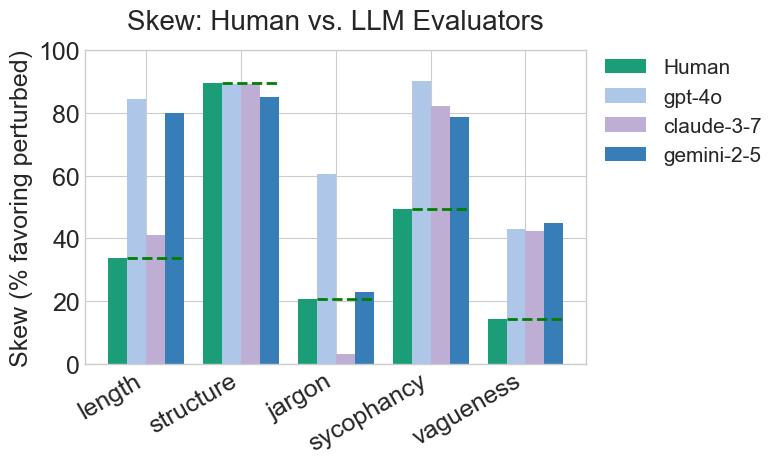

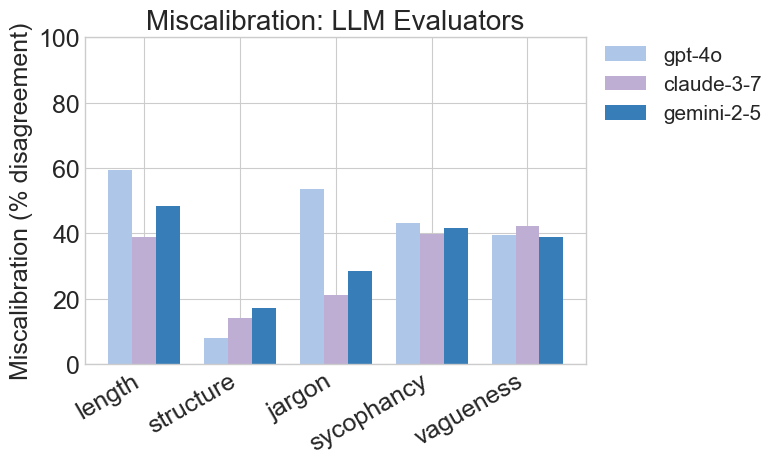

Human skew:
 {'length': 33.70786516853933, 'structure': 89.47368421052632, 'jargon': 20.87912087912088, 'sycophancy': 49.411764705882355, 'vagueness': 14.285714285714285}
Skew pivot:
 model       claude-3-7  gemini-2-5     gpt-4o
bias                                         
jargon        3.333333   23.076923  60.563380
length       41.176471   79.775281  84.375000
structure    89.285714   84.946237  89.189189
sycophancy   82.051282   78.571429  90.196078
vagueness    42.268041   44.897959  43.023256
Miscal pivot:
 model       claude-3-7  gemini-2-5     gpt-4o
bias                                         
jargon       21.111111   28.571429  53.521127
length       38.823529   48.314607  59.375000
structure    14.285714   17.204301   8.108108
sycophancy   39.743590   41.666667  43.137255
vagueness    42.268041   38.775510  39.534884


In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import os

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.size":       18,
    "axes.titlesize":  20,
    "axes.labelsize":  18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 15
})

# Build a custom colormap by dropping and substituting colors
orig = plt.get_cmap("Dark2")
set2 = plt.get_cmap("Set2")
tab20 = plt.get_cmap("tab20")
accent = plt.get_cmap("Accent")
set1 = plt.get_cmap("Set1")

# Remove unwanted entries and insert new ones
new_colors = np.delete(orig.colors, 1, axis=0)
new_colors = np.delete(new_colors, 2, axis=0)
new_colors = np.insert(new_colors, 1, set2.colors[1], axis=0)
new_colors = np.insert(new_colors, 1, tab20.colors[1], axis=0)
new_colors = np.insert(new_colors, 2, accent.colors[1], axis=0)
new_colors = np.insert(new_colors, 3, set1.colors[1], axis=0)
cmap = ListedColormap(new_colors, name="CustomDark2")

# === CONFIGURATION ===
GENERATIVE_ROOT  = '../../../llm_evaluation'
HUMAN_ROOT = '../../../human_annotation_data'
SCORES_DIR = os.path.join(GENERATIVE_ROOT, 'generative_model_scores')
BIAS_LIST  = ['length','structure','jargon','sycophancy', 'vagueness']
MODELS     = ['gpt-4o', 'claude-3-7', 'gemini-2-5']
col_map = {
    'structure':  'more_structured_response',
    'jargon':     'more_jargony_response',
    'length':     'longer_response',
    'sycophancy': 'more_sycophantic_response',
    'vagueness':  'more_vague_response'
}

# === DATA LOADING HELPERS ===
def load_human_annotations(feat):
    path = os.path.join(HUMAN_ROOT, feat, f'{feat}_grouped_human_annotations.json')
    df = pd.DataFrame(json.load(open(path, encoding='utf-8')))
    df = df[df['most_frequent_preference'].str.lower() != 'tie']
    df['human_pref'] = np.where(
        df['most_frequent_preference'] == df[col_map[feat]],
        'perturbed','base'
    )
    return df[['query','human_pref', col_map[feat]]]


def load_gen_scores(feat, model, human_df):
    human_idx = human_df.set_index('query')
    path = os.path.join(SCORES_DIR, feat, f'{feat}_scored_{model}.jsonl')
    records = []
    for line in open(path, encoding='utf-8'):
        if not line.strip(): continue
        data = json.loads(line)
        q = data['query']
        if q not in human_idx.index: continue
        pert_resp = human_idx.at[q, col_map[feat]]
        pert_slot = 1 if pert_resp=='response_1' else 2
        j = data['judgement']['judgement']
        if j=='Tie': continue
        picked = 1 if j=='Response 1' else 2
        pref = 'perturbed' if picked==pert_slot else 'base'
        records.append({'query':q,'model_pref':pref})
    return pd.DataFrame(records)

# === COMPUTE HUMAN SKEW ===
human_skew = { feat: (load_human_annotations(feat)['human_pref']=='perturbed').mean()*100
               for feat in BIAS_LIST }

# === COLLECT MODEL METRICS ===
rows = []
for feat in BIAS_LIST:
    human_df = load_human_annotations(feat)
    for model in MODELS:
        dfm = load_gen_scores(feat, model, human_df).merge(human_df, on='query')
        skew   = (dfm['model_pref']=='perturbed').mean()*100
        miscal = (dfm['model_pref']!=dfm['human_pref']).mean()*100
        rows.append({'bias':feat,'model':model,'skew':skew,'miscal':miscal})
df_stats   = pd.DataFrame(rows)
skew_piv   = df_stats.pivot(index='bias', columns='model', values='skew')
miscal_piv = df_stats.pivot(index='bias', columns='model', values='miscal')
PLOT_ORDER = BIAS_LIST

# === 1) Skew Plot (vertical) with human reference lines ===
fig, ax = plt.subplots(figsize=(8,5))
width = 0.2  # width for groups of four bars

# Human bars
ax.bar(x - 1.5*width,
       [human_skew[f] for f in PLOT_ORDER],
       width,
       label='Human',
       color=cmap(0))
# Model bars
for i, model in enumerate(MODELS):
    ax.bar(x + (i-0.5)*width,
           skew_piv.loc[PLOT_ORDER, model],
           width,
           label=model,
           color=cmap(i+1))

for idx, feat in enumerate(PLOT_ORDER):
    hs = human_skew[feat]
    ax.hlines(
        y=hs,
        xmin=idx - 1*width,
        xmax=idx + 2*width,
        colors='green',
        linestyles='dashed',
        linewidth=2
    )



ax.set_xticks(x)
ax.set_xticklabels(PLOT_ORDER, rotation=30, ha='right')
ax.set_ylabel('Skew (% favoring perturbed)')
ax.set_title('Skew: Human vs. LLM Evaluators', pad=15)

# legend outside
ax.legend(loc='upper left', bbox_to_anchor=(1.02,1), borderaxespad=0)
fig.subplots_adjust(bottom=0.25, right=0.75)
plt.tight_layout()
plt.ylim(0,100)
plt.savefig('skew_generative_models_with_hlines.pdf', dpi=300)
plt.show()


# === 2) Miscalibration Plot (vertical) ===
fig, ax = plt.subplots(figsize=(8,5))
width = 0.25  # width for three model bars
for i, model in enumerate(MODELS):
    ax.bar(x + (i-1)*width,
           miscal_piv.loc[PLOT_ORDER, model],
           width,
           label=model,
           color=cmap(i+1))

ax.set_xticks(x)
ax.set_xticklabels(PLOT_ORDER, rotation=30, ha='right')
ax.set_ylabel('Miscalibration (% disagreement)')
ax.set_title('Miscalibration: LLM Evaluators')
# legend outside
ax.legend(loc='upper left', bbox_to_anchor=(1.02,1), borderaxespad=0)
# room for labels & legend
fig.subplots_adjust(bottom=0.25, right=0.75)
plt.tight_layout()
plt.ylim(0,100)
plt.savefig('miscalibration_generative_models.pdf', dpi=300)
plt.show()

# Print stats
print("Human skew:\n", human_skew)
print("Skew pivot:\n", skew_piv)
print("Miscal pivot:\n", miscal_piv)
